# Intro

Supervised machine learning focuses on making accurate predictions. But it is our actions that influence the world, and predictions are useful only as inputs into improve decision-making. So models that effectively optimize actions will be more valuable than those that only make predictions.

Reinforcement learning (RL) is the leading approach to optimizing optimizing actions. But mainstream RL faces major barriers to widespread adoption. This notebook outlines a decision optimization approach that I believe is practical in most applications where supervised ML is used today. Most of the notebook is an example going through this workflow.

The workflow is:
1. Encode a practitioners domain knowledge into a model. This model is called the **structural model** because it takes a form common in strucural econometrics and structural equation modeling. The structural model differs from common statistical and ML models by including multiple equations (which are interconnected because some variables show up in multiple equations.) 
2. Use pre-existing data to estimate the unknown parameters of the structural model. More detail on this below.
3. Treat the estimated model as a simulation environment. Optimize the decision policy in this simulation environment.
4. Apply that decision policy in the real business environment

### Differences from Conventional RL

This approach differs from mainstream RL in three important ways:

1. The RL community generally prefers not to rely on human engineered models. I go the opposite direction, applying human knowledge as much as possible in the structural model.

2. RL research is computationally difficult because it is applied to problems with high dimensional state spaces (e.g. robotics and video games). I focus on the types of problems where supervised ML is currently applied. These problems have orders of magnitude smaller state spaces. Optimization in these low dimensional spaces is faster and more stable than optimization in high dimensional spaces.

3. RL agents learn by interacting directly with the environment. Few businesses would allow an untrained agent to experiment with their important business decisions. So the proposed workflow does optimization offline (in the simulator). Only the optimized policy is ever deployed to a real environment.


> Though I use a model, this workflow is not conventional model-based reinforcement learning, because the model of the environment isn't updated during policy optimization. This difference flows from the goal of doing policy optimization outside of the real environment.
This approach is closer to [World Models](https://arxiv.org/abs/1803.10122). But World Models avoids human knowledge when building the simulator, relying instead on standard deep learning models. My approach would fail in the World Models testbed (a video game) because humans have little intuition in the pixel space. But humans have good intuitions about the problems I aim to solve, and that knowledge is a beneficial regularizer in my proposed workflow.

# Example Applications

### Airline Pricing
Airlines already use machine learning models to help set ticket prices. The ML model predicts how many tickets the airline can sell each day for each upcoming flight for each candidate price. The models consider price, seasonablity, competitor prices, macroeconomic variables, etc. But even a perfect predictive model doesn't guarantee efficient price setting.

For example, consider a flight happening in 100 days which currently has 150 unsold seats. A predictive model says you can sell 1 ticket today for \\$300 or you could sell 2 tickets if you set the price at $250. Which price should you choose? 

Airlines currently convert predictive models into pricing decisions with heuristics (e.g. a timetable of how many tickets to sell at pre-specified periods before the flight, or a goal of selling up to a pre-specified demand elasticity.)

I believe formal optimization promises a major improvement over these rule-of-thumb approaches.

### Grocery Store Logistics
A grocery chain ran a [predictive modeling competition on Kaggle](https://www.kaggle.com/c/favorita-grocery-sales-forecasting) to improve demand forecasts. They aimed to stock match their purchases from wholesales to their retail sales. However, the predicted sales is not always the optimal amount to stock.

If you purchase exactly the amount you are predicted to sell, you will experience frequent stockouts (when your model underestimates demand), reducing sales volume and disappointing customers.  Similarly, some items will spoil when predicted sales exceed actual sales. Unless the model is exactly correct every time, you face a tradeoff.  The optimal decision would consider factors like
- Markup rate on each item
- Spoilage rate
- Cost of storage
- Value of ensuring customers find the items they want
- etc.

In practice, grocery store managers likely guess at how to make these tradeoffs, much as they may have guessed at how much of each food they would sell before adopting ML. But the approach in this notebook would help them make better decisions.


# Implemented Example
This notebook focuses on the Airline Pricing example. Specifically, I train an agent to set prices for Jetblue. The competitor, whose prices we cannot control, is called Delta. 

To illustrate the how resulting pricing policies perform in the original data generating environment, I use a simulation for the data generating process rather than using real data. Though I take a fixed dataset for trainng the predictive model in the conventional way. For illustrative simplicity, this example considers a market with only two airlines.

### The Two Models

I use two models:
The **structural model** defines the parts of the market that a domain expert can specify. The structural model used in this example is straightforward.  It is implemented in this code [This code](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/market.py#L45).

The key facts encoded in the model are:

Each flight starts with a fixed number of available seats and a fixed number of days to departure. 

Each day until the flight happens
- airlines can update the ticket price daily
- the number of seats available decreases by the number of seats that airline sells
- the number of days until the flight decreases by 1
- accumulated revenue for the flight increases by `ticket_price * seats_sold`
- airlines cannot sell more seats than the plane has, and sales stop when the plane takes off (this model ignores overbooking, though someone more knowledgeable might add it to the model)



The second model is the **predictive model**, which captures things the airline is uncertain about:
- How their competitor sets prices
- How many seats each airline will sell on each day (as a function of daily demand shocks and each airline's price)

The predictive model used here is a [deep learning model](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/keras_models.py#L22). The structural model is completely deterministic once it receives the predictions from the predictive model.

> Aside: Structural econometrics has historically incorporated all uncertainty into the structural model, and not used a separate predictive model. This requires specifying all functional forms in the model and estimating those parameters directly (e.g. with maximum likelihood estimation). That workflow has the shortcomings of standard GLM style modeling ((poor predictive accuracy due to underfitting). Abstracting the sources of uncertainty into a separate predictive model allows the flexibility to use modern ML.

> Second Aside: I explored representing the structural and predictive models together using PyMC3. This allow estimating full Bayesian posteriors. This has a potentially large benefit for decision optimization (related to Jensen's inequality). I found it difficult to simulate market dynamics in PyMC3. I'll revisit probabilistic programming for this purpose, likely after the release of PyMC4.

### Implementation Details
The code captures the two models in two objects:
- A `CompetitiveConditions` object contains the predictive model. It captures pricing strategies and the process for determining how many tickets are sold. When generating training data, the `CompetitiveConditions` object holds the true data generating process for pricing and quantity determination (rather than a predictive model). The data generating is unlike the predictive models that approximate it. Details of the data generating process for price and quantity determination aren't central to my workflow, so their description is saved for the end of this notebook.

- A `Market` object contains the logic for the structural model. The `market` object takes `CompetitiveConditions` as an argument, so predictions about market dynamics can be plugged into the structural model.

`Market` follows the standard OpenAI Gym API, so standard RL tools can be used to optimize pricing policies in our model based environment.

# Step 1: Collect Data From Real Market

I define parameters and import a pricing function for use in the true data generating process. The exact market mechanisms (which the constants below affect) aren't central to explaining my modeling and optimization approach. So the description of market mechanics is postponed to the bottom of this notebook.

For now, you can treat the quantity-determining mechanism and it's parameters as a black box, much as the airlines do.

In [2]:
import numpy as np
import pandas as pd

from sem_policy_opt.true_dgp import get_true_qty_demanded_fn


# Constants hidden from airlines
CUSTOMER_LEVEL_RANDOMNESS = 20 # Std. Dev of idiosyncratic custom preference between airlines
DEMAND_SIGNAL_NOISINESS = 20  # Std. Dev of noise in how airlines' obversve daily traffic shocks
MAX_DEMAND_LEVEL = 400 # The most any customer will ever pay
POTENTIAL_CUSTOMERS_PER_DAY = 20 # Number of unique agents on consumer side of data generating process
FLIGHTS_IN_TRAINING_DATA = 250
FLIGHTS_IN_VAL_DATA = 25

# Constants known to airlines
SEATS_PER_FLIGHT = 250 
SALES_WINDOW_LENGTH = 120 # Length of time airline has to sell tickets before flight takes off


I used trial and error to find a reasonable pricing function. I use the following function for both airlines when creating "real" data.

In [3]:
def simple_price_fn(my_demand_signal, days_before_flight, my_seats_avail, competitor_full): 
    # Charge more if you have a lot of time to sell seats, if few seats are available, or if you have little competition
    # On net, prices may increase over time because low seat inventory overwhelms remaining time effect.
    formula_price = 50 + my_demand_signal + 0.6 * days_before_flight - my_seats_avail + 40 * int(competitor_full)
    # demand_signal is noisy and can thus be negative. Never price tickets below some price_floor
    price_floor = 10
    actual_price = max(formula_price, price_floor)
    return actual_price


# Step 1: Collect Training Data from Real Market

Airlines have historical data they can use to build a model. Here, I run the "real" environment to create training data.

In [4]:
from sem_policy_opt.market import Market
from sem_policy_opt.market_conditions import CompetitiveConditions
from sem_policy_opt.diagnostics import run_env

real_market_conditions = CompetitiveConditions(delta_price_fn = simple_price_fn, 
                                               qty_fn=get_true_qty_demanded_fn(POTENTIAL_CUSTOMERS_PER_DAY, CUSTOMER_LEVEL_RANDOMNESS))

real_market = Market(real_market_conditions, MAX_DEMAND_LEVEL, DEMAND_SIGNAL_NOISINESS, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH) 

train_profits, train_data = run_env(real_market, simple_price_fn, n_times=FLIGHTS_IN_TRAINING_DATA)
val_profits, val_data = run_env(real_market, simple_price_fn, n_times=FLIGHTS_IN_VAL_DATA)

# Step 2: Fit Predictive Model on Real Data

We use the training data to fit a model that predicts Delta's price and the quantity sold as a function of
- Days remaining
- Jetblue's demand signal
- Jetblue's remaining number of seats available
- Whether Delta's flight is fully booked (i.e. whether Delta is still selling tickets)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [cross_signal_coeff_on_qty, cross_price_coeff_on_qty, price_coeff_on_qty, demand_signal_coeff_on_qty, purchase_prob_intercept, cross_demand_signal_coeff_on_price]
>Metropolis: [potential_customers]
Sampling 4 chains: 100%|██████████| 8000/8000 [11:10<00:00,  4.96draws/s]
The acceptance probability does not match the target. It is 0.8965710509664527, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900540005569527, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916019998732255, but should be close to 0.8. Try to increase the number of tuning steps.
Only 50 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [cross_signal_coeff_on_qty, cross_price_coeff_on_qty, price_coeff_on_qty, demand_signal_coeff_on_qty, purchase_prob_inte

r-squared values for predictive model:


{'delta_price': -3.59, 'jb_qty_sold': 0.27, 'delta_qty_sold': 0.13}

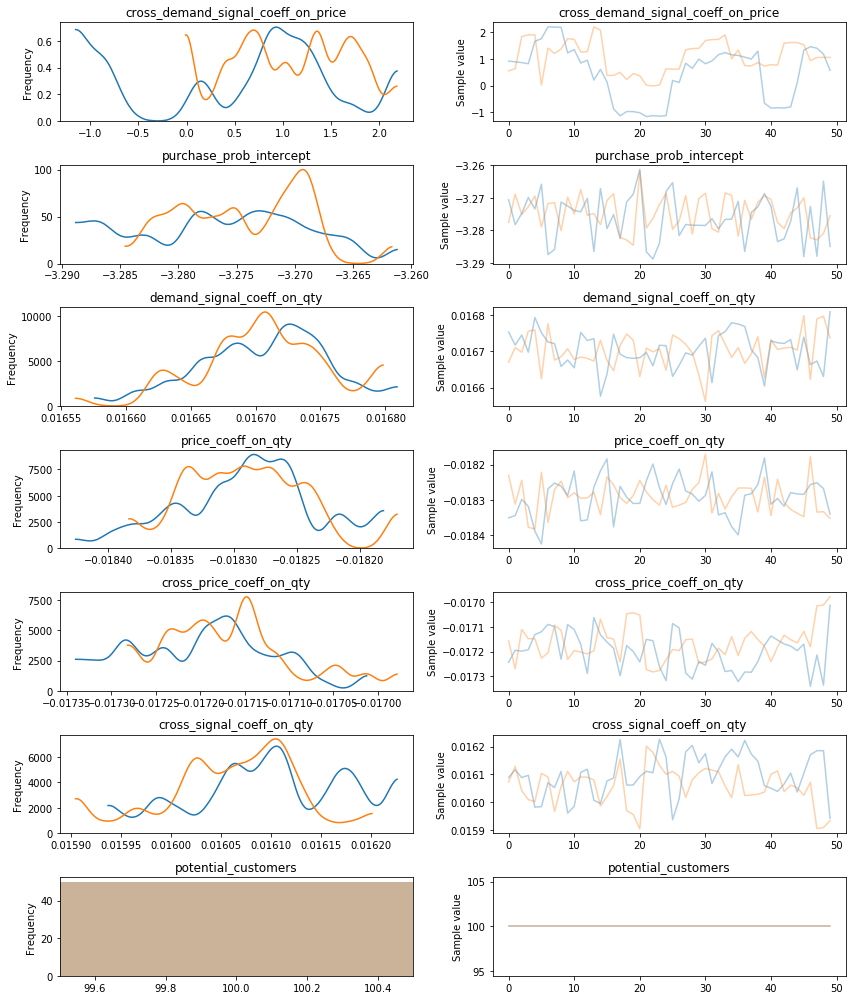

In [51]:
%load_ext autoreload
%autoreload 2
import pymc3 as pm
from sem_policy_opt.pymc_models import WrappedPymcModel
from sem_policy_opt.diagnostics import r_squared

predictive_model = WrappedPymcModel(train_data)

with predictive_model.model:
    trace = pm.sample(100)
    pm.traceplot(trace)

print('r-squared values for predictive model:')
r_squared(predictive_model, val_data)

# Step 3: Set Up Model-Based Market Simulator

I create a market based not on the true data generating processes (which the Jetblue doesn't know), but instead based on the predictive model.

In [52]:
sim_market_conditions = CompetitiveConditions(predictive_model=predictive_model)
sim_market = Market(sim_market_conditions, MAX_DEMAND_LEVEL, DEMAND_SIGNAL_NOISINESS, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH)


As a diagnostic, I compare predicted profits from using Jetblue's current pricing function in the training, validation and simulator data.

In [50]:
simple_price_sim_profits, simple_price_sim_data = run_env(sim_market, simple_price_fn, n_times=20)

print("Mean profits in training data: ${:,.0f} \n"
      "Mean profits in val data: ${:,.0f} \n"
      "Mean profits in sim data: ${:,.0f} \n".format(train_profits.mean(), val_profits.mean(), simple_price_sim_profits.mean()))

IndexError: invalid index to scalar variable.

### Step 3.1 Model Diagnostics
This modeling set-up allows a wide range of diagnostics counterfactual tests. I don't explore those here, though we would do this to improve the model in a real application. As a first example, I plot a demand curve and cross-price demand curve showing how predicted ticket sales vary with respect to Jetblue's prices (holding other factors constant.

In [ ]:
days_before_flight = jb_demand_signal = 150
pred_outcomes_diff_jb_prices = []
for jb_price in np.linspace(0, MAX_DEMAND_LEVEL, 6):
    # Some extra munging here do to messiness associated with multi-input / multi-output model.
    # each input fed in as separate array to facilitate hiding jetblue_price from prediction of delta_price
    prediction_data = prep_for_keras_model([days_before_flight, jb_demand_signal, jb_price], skip_y=True)
    prediction = predictive_model.predict(prediction_data)
    delta_price, jb_seats_sold, delta_seats_sold = [round(i[0][0]) for i in prediction]
    pred_outcomes_diff_jb_prices.append({'jb_price': jb_price,
                                         'delta_price': delta_price,
                                         'jetblue_seats_sold': jb_seats_sold,
                                         'delta_seats_sold': delta_seats_sold})
pd.DataFrame(pred_outcomes_diff_jb_prices).set_index(['jb_price'])

It isn't surprising that delta price is independent of **jb_price**. The structural model asserts that neither airline sees the other price on any given day before they choose their own.  However, any non-monotonicities in the `seats_sold` predictions are limitations of the predictive model.

Even with an imperfect model, pricing policy optimization can work well, with optimized policies yielding far greater profits in the real environment than the baseline pricing function did.

# Step 4: Optimize Policy Function
We could use an arbitrary optimization procedure to optimize our policy. The appendix contains a Soft Actor Critic optimizer, and I may experiment with other optimizers in the future. For now, I use a simple grid search. Pricing policies are created as linear functions of the state variables
- Daily demand signal
- Days remaining before flight
- Seats available
- Whether the competitor's flight is full

I try various multipliers of these state variables. The pricing equation is specified more precisely [here](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/diagnostics.py#L9).

The optimization code is below.

In [ ]:
from collections import OrderedDict
from itertools import product
from time import time
from sem_policy_opt.diagnostics import pricing_fn_creator, get_real_and_sim_rewards

optim_start_time = time()

# Create points in grid of pricing policies to be considered during optimization
intercepts = np.linspace(0, 200, 4)
demand_signal_mults = np.linspace(0, 1, 4)
days_before_flight_mults = np.linspace(0, 1, 4)
seats_avail_mults = np.linspace(-1, 0, 3)
competitor_full_mults = np.linspace(0, 100, 3)
price_floors = np.linspace(0, 100, 3)

pricing_combinations = product(intercepts, demand_signal_mults, days_before_flight_mults, 
                               seats_avail_mults, competitor_full_mults, price_floors)

pricing_fns = [pricing_fn_creator(*params) for params in pricing_combinations]
real_and_sim_rewards = get_real_and_sim_rewards(real_market, sim_market, pricing_fns)

print("Optimation time: {}".format(int(time()-optim_start_time)))

A firm would select the policy that returns the highest predicted profit in simulation (since simulation is all they can see before implementing a new policy). This process is effective to the extent the policy generates higher profits in the true market environment. Predicted and real profits from various policies are shown in the following graph.

In [ ]:
from matplotlib import style
style.use('fivethirtyeight')

from sem_policy_opt.diagnostics import plot_optim_results

plot_optim_results(real_and_sim_rewards, 
                   baseline_real_profits=val_profits.mean(), 
                   baseline_sim_profits=simple_price_sim_profits.mean())

# Sensitivity Analysis

The optimization process appears effective. Did this hinge critically on the quality of the predictive model?

The firm predicts demand each day from a "demand signal", and we have a variable that specifies how noisy these signals are.

The following test varies the amount of noise in the demand signal. This in turn varies the quality of the predictive model (i.e. as measured with r-squared). The result shows the relationship between quality of the predictive model and effectiveness of policy optimization.

In [ ]:
%load_ext autoreload
%autoreload 2

from sem_policy_opt.diagnostics import sensitivity_analysis

noisy_real_market_maker = lambda demand_noisiness: Market(real_market_conditions, MAX_DEMAND_LEVEL, demand_noisiness, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH)
noisy_sim_market_maker = lambda demand_noisiness, sim_conditions: Market(sim_conditions, MAX_DEMAND_LEVEL, demand_noisiness, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH)

sensitivity_results = sensitivity_analysis(noisy_real_market_maker, 
                                           noisy_sim_market_maker, 
                                           noise_levels = [20, 50, 100, 250],
                                           pricing_fns=pricing_fns,
                                           flights_in_training_data = FLIGHTS_IN_TRAINING_DATA,
                                           baseline_price_fn=simple_price_fn)
sensitivity_results

Real profits from policy optimization decrease as the environment gets noisier (and the model gets worse). This is due to worsening optimization (and not a change in the best possible policy), as the real profits from a perfectly chosen policy remain high.

Optimization beats the baseline in all circumstances, though this may be an unfair comparison as the baseline policy was chosen from ad-hoc experimentation when the baseline noise level was 20.

Fortunately, simulated profits are close to real profits in all cases. So a firm would have a reasonable estimate of real profits before deploying any policy.

# Concerns
Price optimization nearly doubled real profits in the main example, and it consistently improved them. But I see three primary objections to this example:

1) This improvement is over a baseline I created through trial and error, not a policy used in the real world (I certainly don't mean to suggest that a Fortune 500 company could double revenue this easily).

2) This example is a somewhat simple problem: there are only two airlines and we didn't account for factors like seasonality. It would be straightforward to include these factors in the model, though I've yet to show how well the process works in a more complex environment.

3) Most concerning, it's unclear how to show that a policy created through optimization will work well without applying it (there's nothing like a test set from supervised ML).

Nevertheless, I believe this approach optimizing decision logic has amazing potential, possibly of the same order of magnitude as what we are seeing from supervised ML.

I appreciate any suggestions and criticisms so I can improve the argument I've started in this notebook.

# Potential Next Steps

I'm currently considering the following next steps:

1. Use PyMC3 for predictive model, and do optimization averaging over multiple simulation environments sampled from the predictive model posterior (to address Jensen's inequality)
2. Abstract out the logic that's universal vs use-case specific
3. Run on real (static) dataset rather than synthetic dataset.

# Appendix

### How The Market In This Example Works
Some number of customers (`POTENTIAL_CUSTOMERS_PER_DAY`) come to a website each day.  The customers' average willingness to pay for a flight on that day `demand_level`. The `demand level` on any given day is chosen from a distribution `uniform(0, MAX_DEMAND_LEVEL)`.  Each airline receives a signal about `demand_level` on that day, and the signal is the `demand_level` plus some noise that is distributed `N(0, DEMAND_SIGNAL_NOISINESS)`. This demand signal might represent a prediction of demand from a model considering seasonality, macroeconomics, etc. Additionally, each customer has idiosyncratic preferences, so their willingness to pay for a ticket on any given airline is `demand_level + customer_preference` where `customer_preference` is distributed `N(0, CUSTOMER_LEVEL_RANDOMNESS)`.  The customer considers the price for each of the two airlines and purchases a ticket from the airline that gives them the highest consumer surplus (their personal willingness to pay minus for a ticket on that airline minus the cost of a ticket on that airline).  If the customer's consumer surplus for both airlines is negative, they do not buy a ticket.

### Optimization Through Modern Reinforcement Learning

The cell below optimizes the pricing policy with Soft Actor Critic (SAC), an RL algorithm that is sample efficient and which is reported to require little hyperparameter tuning.

NOTE: I am sharing this notebook output in Kaggle Kernels. I've not yet been able to install `stable_baselines` in kernels, so I've commented this part out for now. The value of my underlying approach doesn't hinge on whether I do optimization through SAC, grid search (used above) or something else

In [ ]:
if False:    # disabled until I install stable_baselines in Kernels
    from stable_baselines.common.vec_env import DummyVecEnv
    from stable_baselines.sac.policies import MlpPolicy
    from stable_baselines.sac import SAC
    from time import time
    import os

    sim_market_maker = lambda: market_maker(sim_market_conditions)
    
    parallelism_level = 1         # use os.cpu_count() if not using SAC. SAC doesn't allow parallelism
    env = DummyVecEnv([sim_market_maker for _ in range(parallelism_level)]) # Env is vectorized market for parallelism
    total_learning_steps = 750000
    steps_per_update = 10000
    optim_results = []

    model = SAC(MlpPolicy, env)

    start_time = time()
    for step in range(0, total_learning_steps+1, steps_per_update):
        model.learn(total_timesteps=steps_per_update)
    
        mean_sim_reward = run_env(sim_market_maker, model, n_times=5)[0].mean()
        mean_real_reward = run_env(real_market_maker, model, n_times=5)[0].mean()
        optim_results.append(dict(step=step, 
                                  time=time()-start_time,
                                  sim_profit=mean_sim_reward,
                                  real_profit=mean_real_reward))
    
        print("""{} timesteps used for learning in {:.0f} seconds. 
                 Current score in sim: {:.0f}. Current score in real market: {:.0f}.""".format(
                                                                                step,
                                                                                time()-start_time, 
                                                                                mean_sim_reward, 
                                                                                mean_real_reward))
    optim_results_df = pd.DataFrame(optim_results)
    optim_results_df.plot.line(x='step', y=['sim_profit', 'real_profit'])